#### DCGAN- Deep convolutional Generative adversarial networks 

In [87]:
import torch 
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter



In [88]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super().__init__()
        self.disc=nn.Sequential(
            #Input : N* channels_img*64*64
            nn.Conv2d(in_channels=channels_img,out_channels=features_d,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self._block(in_channels=features_d,out_channels=features_d*2,kernel_size=4,stride=2,padding=1),
            self._block(in_channels=features_d*2,out_channels=features_d*4,kernel_size=4,stride=2,padding=1),
            self._block(in_channels=features_d*4,out_channels=features_d*8,kernel_size=4,stride=2,padding=1),
            nn.Conv2d(in_channels=features_d*8,out_channels=1,kernel_size=4,stride=2,padding=0),
            nn.Sigmoid()
            
        )
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.disc(x)

In [89]:
class Generator(nn.Module):
    def __init__(self,z_dim,channels_img,features_g):
        super().__init__()
        self.gen=nn.Sequential(
            #Input: N*z_dim*1*1
            self._block(in_channels=z_dim,out_channels=features_g*16,kernel_size=4,stride=1,padding=0), #N*features_g*16*4*4
            self._block(in_channels=features_g*16,out_channels=features_g*8,kernel_size=4,stride=2,padding=1), # 8*8
            self._block(in_channels=features_g*8,out_channels=features_g*4,kernel_size=4,stride=2,padding=1), #16*16
            self._block(in_channels=features_g*4,out_channels=features_g*2,kernel_size=4,stride=2,padding=1), #32*32
            nn.ConvTranspose2d(in_channels=features_g*2,out_channels=channels_img,kernel_size=4,stride=2,padding=1),
            nn.Tanh() # [-1,1]
        )

    
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self,X):
        return self.gen(X)
        

In [90]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)
      

In [91]:
def test():
    N,in_channels,H,W=8,3,64,64
    z_dim=100
    X=torch.randn(size=(N,in_channels,H,W))
    disc=Discriminator(channels_img=in_channels,features_d=8)
    initialize_weights(disc)
    assert disc(X).shape ==(N,1,1,1)
    gen=Generator(z_dim,in_channels,8)
    initialize_weights(gen)
    z=torch.randn((N,z_dim,1,1))
    assert gen(z).shape ==(N,in_channels,H,W)
    print("success")

test()

success


In [92]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

Using device:cuda


In [93]:
LEARNING_RATE=2e-4
BATCH_SIZE=128 
IMAGE_SIZE=64
CHANNELS_IMG=1
Z_DIM=100
NUM_EPOCHS=5
FEATURES_DISC=64
FEATURES_GEN=64

transforms=transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)],[0.5 for _ in range(CHANNELS_IMG)])
])

In [94]:
dataset=datasets.MNIST(root='dataset',train=True,transform=transforms,download=True)
dataloader=DataLoader(dataset=dataset,batch_size=BATCH_SIZE,shuffle=True)

In [95]:
gen=Generator(z_dim=Z_DIM,channels_img=CHANNELS_IMG,features_g=FEATURES_GEN).to(device)
disc=Discriminator(channels_img=CHANNELS_IMG,features_d=FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)


In [96]:
opt_gen=optim.Adam(params=gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
opt_disc=optim.Adam(params=disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
criterion=nn.BCELoss()


In [97]:
fixed_noise=torch.randn(32,Z_DIM,1,1).to(device)
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step=0
gen.train()
disc.train()


Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [98]:
for epoch in range(NUM_EPOCHS):
    for batch_idx,(real,_) in enumerate(dataloader):
        real=real.to(device)
        noise=torch.randn((BATCH_SIZE,Z_DIM,1,1)).to(device)
        fake=gen(noise).to(device)
        ##Train discriminator max log(D)(X)) + log(1-D(G(Z)))
        disc_real=disc(real).reshape(-1)  ###N*1*1 -->N
        loss_disc_real=criterion(disc_real,torch.ones_like(disc_real))
        disc_fake=disc(fake).reshape(-1)
        loss_disc_fake=criterion(disc_fake,torch.zeros_like(disc_fake))
        loss_disc=(loss_disc_real+loss_disc_fake)/2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        ##Train generator  -->Min log(1-D(G(z))) <--> Max log(D(G(z)))
        output=disc(fake).reshape(-1)
        loss_gen=criterion(output,torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
         
        


Epoch [0/5] Batch 0/469                   Loss D: 0.6935, loss G: 0.7902
Epoch [0/5] Batch 100/469                   Loss D: 0.0145, loss G: 4.1591
Epoch [0/5] Batch 200/469                   Loss D: 1.1281, loss G: 1.7642
Epoch [0/5] Batch 300/469                   Loss D: 0.6370, loss G: 0.8190
Epoch [0/5] Batch 400/469                   Loss D: 0.6475, loss G: 1.4214
Epoch [1/5] Batch 0/469                   Loss D: 0.6572, loss G: 0.6475
Epoch [1/5] Batch 100/469                   Loss D: 0.6378, loss G: 1.0994
Epoch [1/5] Batch 200/469                   Loss D: 0.9483, loss G: 1.9500
Epoch [1/5] Batch 300/469                   Loss D: 0.6911, loss G: 0.7945
Epoch [1/5] Batch 400/469                   Loss D: 0.5948, loss G: 0.9025
Epoch [2/5] Batch 0/469                   Loss D: 0.6434, loss G: 0.9042
Epoch [2/5] Batch 100/469                   Loss D: 0.7001, loss G: 0.7547
Epoch [2/5] Batch 200/469                   Loss D: 0.5729, loss G: 0.9842
Epoch [2/5] Batch 300/469      

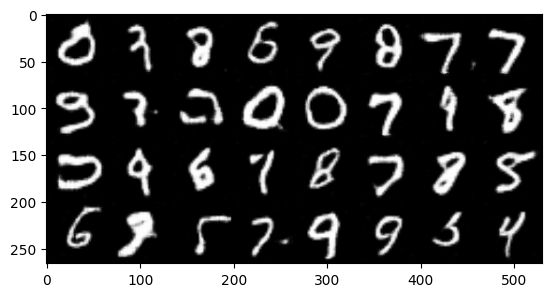

In [100]:
import matplotlib.pyplot as plt

plt.imshow(img_grid_fake.permute(1,2,0).cpu().numpy())